In [1]:
#In the name of God

student_id = 401210923
student_name = "Navid Farahani"

print("your student id:", student_id)
print("your name:", student_name)

print(" For better understanding the Forward-Forward algorithm, I used watched this video : https://www.youtube.com/watch?v=kvdOow3__CI")
print(" For explaining the codes, I wrote comment for them.")
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
import random

your student id: 401210923
your name: Navid Farahani
 For better understanding the Forward-Forward algorithm, I used watched this video : https://www.youtube.com/watch?v=kvdOow3__CI
 For explaining the codes, I wrote comment for them.


In [2]:

## Part A
# Selecting the device:

if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

# choosing number of images, number of test images are considered 1/5 of train's

num_train=50000
num_test=num_train//5

# If the device is GPU, we determine num_workers
if torch.cuda.is_available():
    cuda_kwargs = {"num_workers": 3, "pin_memory": True, "shuffle": True}
    # train_kwargs.update(cuda_kwargs)
    # test_kwargs.update(cuda_kwargs)

# we use pytorch for MNISt data, so we can apply a transform to images for normaliaztion with zero mean and unit std.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,)),])

#determining test and train images

trainset = MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=num_train, shuffle=True)


testset = MNIST('~/.pytorch/MNIST_data/',download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=num_test,shuffle=False)

# taking variables to device and vectorizing the images.
x,y=next(iter(train_loader))
x,y=x.to(device),y.to(device)
x=torch.reshape(x,(num_train,x.shape[2]*x.shape[3]))


100%|██████████| 9912422/9912422 [00:00<00:00, 93963204.67it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58042977.40it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36659518.04it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2323518.57it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Text(0.5, 1.0, 'Negative Data')

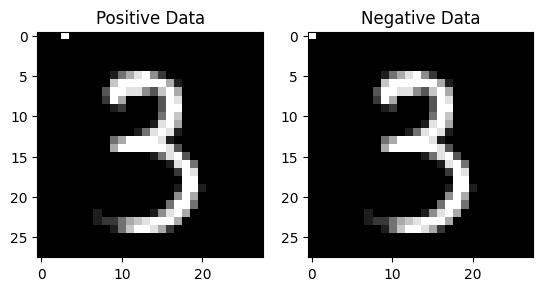

In [3]:
## Part B

# according to the article, we need to put the one-hot labels on the images for classification
# so we wrote combined_image function
def combined_image(x, y):
    x_and_y=x.clone()
    x_and_y[:,:10]=0.0
    xlabels=range(x.shape[0])
    x_and_y[xlabels,y]=1
    return x_and_y

# we have a one-hot vector for every images, so for negative images we need to shuffle that vector.
# so we wrote shuffled_y function

def shuffled_y(y):
    y=y.to('cpu')
    y=y.numpy()
    y_shuffled=np.zeros(y.shape,np.uint8)
    for i in range(np.shape(y)[0]):
        y_shuffled[i]=np.random.randint(10)
        while(y_shuffled[i]==y[i]):
            y_shuffled[i]=np.random.randint(10)
    y_shuffled=torch.from_numpy(y_shuffled)
    return y_shuffled.to(device)




# positive data is combining labels and the images
x_positive = combined_image(x, y)

# negative data is combining shuffled labels and the images.
y_negative = shuffled_y(y)
y3=torch.zeros_like(y)
y3[:]=y_negative[:]
x_negative = combined_image(x, y3)


# for better understanding, I plot an image fo positive and negative images.

index_for_img=np.random.randint(num_train)
plt.subplot(1,2,1)
the_img_pos=torch.reshape(x_positive[index_for_img,:],(28,28))
the_img_pos=the_img_pos.to('cpu')
the_img_numpy_pos=the_img_pos.numpy()
plt.imshow(np.array(255*the_img_numpy_pos,dtype=np.uint8),cmap='gray')
plt.title("Positive Data")

plt.subplot(1,2,2)
the_img_neg=torch.reshape(x_negative[index_for_img,:],(28,28))
the_img_neg=the_img_neg.to('cpu')
the_img_numpy_neg=the_img_neg.numpy()
plt.imshow(np.array(255*the_img_numpy_neg,dtype=np.uint8),cmap='gray')
plt.title("Negative Data")


In [4]:
## Part C

class TheLayerInNN(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.num_epochs = 1000
        self.threshold = 2 # it seems that the best value for threshold is 2 by doing experiments.


    def forward(self, x):
        #We normalize all x and then do forward pass.
        x=x/(x.norm(2,1,keepdim=True)+1e-4)
        # We do forward pass, (like HW 2, Python Exercise, Question 1) and use ReLU activation function
        # Moreover, we had to add 1 dimension to make the add operator possible between b and xw.T
        z=torch.matmul(x, self.weight.T) + torch.unsqueeze(self.bias,(0))
        return torch.relu(z)

    def train(self,x_positive,x_negative):
        opt_function=Adam(self.parameters(),lr=0.03)
        #In each epoch, we calculate
        for i in range(self.num_epochs):

            # To compute the goodness, we need to use power 2 of x_positive and x_negative to compare them
            # with the threshold.

            # The optimization function is power 2 of the output of the neural.
            # Also we use the mean on all the weights to creat a number of every image.
            # Thus, for every image, we can compare it with a threshold and decide that what class should it be classified

            positive_data=torch.mean(self.forward(x_positive)**2,axis=1)
            negative_data=torch.mean(self.forward(x_negative)**2,axis=1)

            #ccording to objective function mentioned in the quesion we need to concatenate the two parts
            # of the loss, so we have:

            loss=torch.log(1+torch.exp(torch.cat([self.threshold-positive_data,negative_data-self.threshold])))
            loss=torch.mean(loss)

            # we set gradient to zero for calculation a forward gradient according to next lines:
            opt_function.zero_grad()
            loss.backward()

            #We did not use backpropagation, we just update the value of loss by using loss.backward()
            opt_function.step()
            if i%25== 0:
                print("Loss after epoch "+str(i)+" is :"+str(loss.item()))
        #for hardware issues, we use .detach()
        return self.forward(x_positive).detach(), self.forward(x_negative).detach()




class ForwardToForwardNN(torch.nn.Module):
    def __init__(self, dims):

        super().__init__()
        self.layers = []
        # if we have L layers, we need to consider L-1 stages
        #for calculating weights, so we append all the layers:
        L=len(dims)
        for d in range(L-1):
            self.layers=self.layers+[(TheLayerInNN(dims[d],dims[d+1]).to(device))]


    #In all layers, we calculate x_positive and x_negative and pass these arguments through the network.


    def train(self, x_positive, x_negative):
        for i, layer in enumerate(self.layers):
            x_positive,x_negative=layer.train(x_positive,x_negative)



    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            #We consider all labels from 0 to 9 in MNIST data, so
            # we determine x_positive for all these.
            x_positive=combined_image(x,label)
            goodness=[]
            # In all layers of the network, we first, pass the input through network,
            # then calculate loss_function( or goodness )

            # Note that for all goodnesses, we combination
            # the previous value and new value of goodness using "+" with the new list.

            for layer in self.layers:
                x_positive = layer(x_positive)
                goodness=goodness+[torch.mean(x_positive*x_positive,axis=1)]

            goodness_per_label+=[torch.unsqueeze(sum(goodness),(1))]

        #We have 10 classes, so we concatenate features to decide which class has the most probability.
        #by the following code:
        goodness_per_label=torch.cat(goodness_per_label,1)

        #We consider the maximum value among the value that goodness decides as the predicted label.
        return goodness_per_label.argmax(1)




dims=[x.shape[1],256,256]
net=ForwardToForwardNN(dims=dims)
#net=Net([x.shape[1],2000,2000,2000,2000])# it seems that the proposed architecture in the article is too massive!
# so I used a 256*256 hidden layers instead of 2000*2000*2000*2000.

net.train(x_positive,x_negative)


Loss after epoch 0 is :1.1267706155776978
Loss after epoch 25 is :0.7183191776275635
Loss after epoch 50 is :0.7027506232261658
Loss after epoch 75 is :0.6971085667610168
Loss after epoch 100 is :0.6907996535301208
Loss after epoch 125 is :0.6804167032241821
Loss after epoch 150 is :0.6635582447052002
Loss after epoch 175 is :0.6387032866477966
Loss after epoch 200 is :0.6089634895324707
Loss after epoch 225 is :0.5794064998626709
Loss after epoch 250 is :0.5518003702163696
Loss after epoch 275 is :0.5266143083572388
Loss after epoch 300 is :0.5039002895355225
Loss after epoch 325 is :0.48359233140945435
Loss after epoch 350 is :0.4654412865638733
Loss after epoch 375 is :0.4493106007575989
Loss after epoch 400 is :0.4350229501724243
Loss after epoch 425 is :0.4223118722438812
Loss after epoch 450 is :0.4109235107898712
Loss after epoch 475 is :0.4006335735321045
Loss after epoch 500 is :0.3912636637687683
Loss after epoch 525 is :0.3826829493045807
Loss after epoch 550 is :0.374762028

In [5]:
##### Part D

preds=net.predict(x)
accuracy_train=torch.sum(100*(preds==y))/len(preds)
accuracy_train=accuracy_train.to('cpu')
print("Train accuracy:"+str(np.array(accuracy_train))+"%")
print("Train error:"+str(100-np.array(accuracy_train))+"%")
x_test,y_test=next(iter(test_loader))
x_test,y_test=x_test.to(device),y_test.to(device)
x_test=torch.reshape(x_test,(num_test,x_test.shape[2]*x_test.shape[3]))
preds=net.predict(x_test)
accuracy_test=torch.sum(100*(preds==y_test))/len(preds)
accuracy_test=accuracy_test.to('cpu')
print("Test accuracy:"+str(np.array(accuracy_test))+"%")
print("Test error:"+str(100-np.array(accuracy_test))+"%")



Train accuracy:91.397995%
Train error:8.602005004882812%
Test accuracy:91.329994%
Test error:8.670005798339844%


In [6]:
# Unsupervised Learning


# Part A
# For negative images, we have to generate hybrid images, by help of masks.
# These masks are generated randomly with the probability of p=0.1 ==> 0.1 and
# 1-p = 0.9 ==> 0


def combined_image_for_negative(x,masks):
    x_new=torch.zeros(x.shape)
    for i in range(x_new.shape[0]):
        index=np.random.randint(x.shape[0])
        x_new[i,:,:]=torch.multiply(masks[i,:,:],x[i,:,:])+torch.multiply(1-masks[i,:,:],x[index,:,:])


    return x_new


p=0.5
values=[1,0]
probs=[p,1-p]
masks=torch.zeros((x.shape[0], int(np.sqrt(x.shape[1])),int(np.sqrt(x.shape[1]))))
mask=torch.zeros(( int(np.sqrt(x.shape[1])),int(np.sqrt(x.shape[1]))))
for j in range(mask.shape[0]):
   for k in range(mask.shape[1]):
    mask[j,k]=random.choices(values,probs)[0]
for i in range(num_train):
    masks[i,:,:]=mask


Text(0.5, 1.0, 'Hybrid Image')

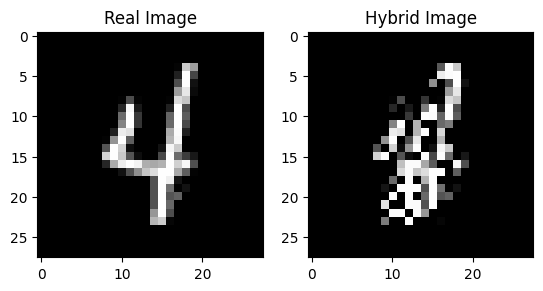

In [7]:
# Part B
x_positive=x
x=x.to('cpu')
x_image=np.reshape(x,(x.shape[0], int(np.sqrt(x.shape[1])),int(np.sqrt(x.shape[1]))))
x_negative=combined_image_for_negative(x_image,masks)
x_negative=torch.reshape(x_negative,(num_train,x_negative.shape[1]*x_negative.shape[2]))
x_negative=x_negative.to(device)
x_positive=x_positive.to(device)
x=x.to(device)
index_for_img=np.random.randint(num_train)
plt.subplot(1,2,1)
the_img_pos=torch.reshape(x_positive[index_for_img,:],(28,28))
the_img_pos=the_img_pos.to('cpu')
the_img_numpy_pos=the_img_pos.numpy()
plt.imshow(np.array(255*the_img_numpy_pos,dtype=np.uint8),cmap='gray')
plt.title("Real Image")
plt.subplot(1,2,2)
the_img_neg=torch.reshape(x_negative[index_for_img,:],(28,28))
the_img_neg=the_img_neg.to('cpu')
the_img_numpy_neg=the_img_neg.numpy()
plt.imshow(np.array(255*the_img_numpy_neg,dtype=np.uint8),cmap='gray')
plt.title("Hybrid Image")


In [9]:
class TheLayerInNN(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.num_epochs = 1000
        self.threshold = 2 # it seems that the best value for threshold is 2 by doing experiments.


    def forward(self, x):
        #We normalize all x and then do forward pass.
        x=x/(x.norm(2,1,keepdim=True)+1e-4)
        # We do forward pass, (like HW 2, Python Exercise, Question 1) and use ReLU activation function
        # Moreover, we had to add 1 dimension to make the add operator possible between b and xw.T
        z=torch.matmul(x, self.weight.T) + torch.unsqueeze(self.bias,(0))
        return torch.relu(z)

    def train(self,x_positive,x_negative):
        opt_function=Adam(self.parameters(),lr=0.03)
        #In each epoch, we calculate
        for i in range(self.num_epochs):

            # To compute the goodness, we need to use power 2 of x_positive and x_negative to compare them
            # with the threshold.

            # The optimization function is power 2 of the output of the neural.
            # Also we use the mean on all the weights to creat a number of every image.
            # Thus, for every image, we can compare it with a threshold and decide that what class should it be classified

            positive_data=torch.mean(self.forward(x_positive)**2,axis=1)
            negative_data=torch.mean(self.forward(x_negative)**2,axis=1)

            #ccording to objective function mentioned in the quesion we need to concatenate the two parts
            # of the loss, so we have:

            loss=torch.log(1+torch.exp(torch.cat([self.threshold-positive_data,negative_data-self.threshold])))
            loss=torch.mean(loss)

            # we set gradient to zero for calculation a forward gradient according to next lines:
            opt_function.zero_grad()
            loss.backward()

            #We did not use backpropagation, we just update the value of loss by using loss.backward()
            opt_function.step()
            if i%25== 0:
                print("Loss after epoch "+str(i)+" is :"+str(loss.item()))
        #for hardware issues, we use .detach()
        return self.forward(x_positive).detach(), self.forward(x_negative).detach()




class ForwardToForwardNN(torch.nn.Module):
    def __init__(self, dims):

        super().__init__()
        self.layers = []
        # if we have L layers, we need to consider L-1 stages
        #for calculating weights, so we append all the layers:
        L=len(dims)
        for d in range(L-1):
            self.layers=self.layers+[(TheLayerInNN(dims[d],dims[d+1]).to(device))]


    #In all layers, we calculate x_positive and x_negative and pass these arguments through the network.


    def train(self, x_positive, x_negative):
        for i, layer in enumerate(self.layers):
            x_positive,x_negative=layer.train(x_positive,x_negative)



    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            #We consider all labels from 0 to 9 in MNIST data, so
            # we determine x_positive for all these.
            x_positive=combined_image(x,label)
            goodness=[]
            # In all layers of the network, we first, pass the input through network,
            # then calculate loss_function( or goodness )

            # Note that for all goodnesses, we combination
            # the previous value and new value of goodness using "+" with the new list.

            for layer in self.layers:
                x_positive = layer(x_positive)
                goodness=goodness+[torch.mean(x_positive*x_positive,axis=1)]

            goodness_per_label+=[torch.unsqueeze(sum(goodness),(1))]

        #We have 10 classes, so we concatenate features to decide which class has the most probability.
        #by the following code:
        goodness_per_label=torch.cat(goodness_per_label,1)

        #We consider the maximum value among the value that goodness decides as the predicted label.
        return goodness_per_label.argmax(1)




dims=[x.shape[1],256,256]
net=ForwardToForwardNN(dims=dims)
#net=Net([x.shape[1],2000,2000,2000,2000])# it seems that the proposed architecture in the article is too massive!
# so I used a 256*256 hidden layers instead of 2000*2000*2000*2000.

net.train(x_positive,x_negative)



Loss after epoch 0 is :1.126747727394104
Loss after epoch 25 is :0.712084174156189
Loss after epoch 50 is :0.6959106922149658
Loss after epoch 75 is :0.6687073111534119
Loss after epoch 100 is :0.6175317168235779
Loss after epoch 125 is :0.5543983578681946
Loss after epoch 150 is :0.5010771155357361
Loss after epoch 175 is :0.46638020873069763
Loss after epoch 200 is :0.43862560391426086
Loss after epoch 225 is :0.4152476489543915
Loss after epoch 250 is :0.39578667283058167
Loss after epoch 275 is :0.3793778717517853
Loss after epoch 300 is :0.3652878403663635
Loss after epoch 325 is :0.3529853820800781
Loss after epoch 350 is :0.3420945107936859
Loss after epoch 375 is :0.33233901858329773
Loss after epoch 400 is :0.3235168159008026
Loss after epoch 425 is :0.31547415256500244
Loss after epoch 450 is :0.30809032917022705
Loss after epoch 475 is :0.30127009749412537
Loss after epoch 500 is :0.2949378490447998
Loss after epoch 525 is :0.28903326392173767
Loss after epoch 550 is :0.2835

In [10]:
##### Part D

preds=net.predict(x)
accuracy_train=torch.sum(100*(preds==y))/len(preds)
accuracy_train=accuracy_train.to('cpu')
print("Train accuracy:"+str(np.array(accuracy_train))+"%")
print("Train error:"+str(100-np.array(accuracy_train))+"%")
x_test,y_test=next(iter(test_loader))
x_test,y_test=x_test.to(device),y_test.to(device)
x_test=torch.reshape(x_test,(num_test,x_test.shape[2]*x_test.shape[3]))
preds=net.predict(x_test)
accuracy_test=torch.sum(100*(preds==y_test))/len(preds)
accuracy_test=accuracy_test.to('cpu')
print("Test accuracy:"+str(np.array(accuracy_test))+"%")
print("Test error:"+str(100-np.array(accuracy_test))+"%")



Train accuracy:10.191999%
Train error:89.8080005645752%
Test accuracy:10.309999%
Test error:89.69000053405762%
